# Sylvie Fortier

# Linear Regression

In [2]:
import pandas as pd
import numpy as np

from datetime import datetime
from datetime import timedelta
import datetime

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from statsmodels.formula.api import ols
import statsmodels.api as sm

from sklearn.preprocessing import PowerTransformer

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
df = pd.read_csv('car_data.csv', header = 0, sep = ',')
df.head(2)

Car_Name  Year  Selling_Price  Present_Price  Kms_Driven Fuel_Type  \
0     ritz  2014           3.35           5.59       27000    Petrol   
1      sx4  2013           4.75           9.54       43000    Diesel   

  Seller_Type Transmission  Owner  
0      Dealer       Manual      0  
1      Dealer       Manual      0

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Car_Name       301 non-null    object 
 1   Year           301 non-null    int64  
 2   Selling_Price  301 non-null    float64
 3   Present_Price  301 non-null    float64
 4   Kms_Driven     301 non-null    int64  
 5   Fuel_Type      301 non-null    object 
 6   Seller_Type    301 non-null    object 
 7   Transmission   301 non-null    object 
 8   Owner          301 non-null    int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 21.3+ KB


#### Note: all Dtype are GtG

In [5]:
df.shape

(301, 9)

#### Note: There are 301 observations

In [6]:
df.isnull().values.any()

False

#### Note: There is no missing values in the DF so we are GtG

In [7]:
#Check if there are duplicates

df.duplicated().any() 

True

In [8]:
#Drop duplicates

df.drop_duplicates(inplace = True)

df.shape

(299, 9)

We now have 299 observations moving forward.

# Create dummy variables for the Fuel_Type, Transmission and Seller_Type variables.

In [9]:
print(df['Fuel_Type'].unique())
print(df['Transmission'].unique())
print(df['Seller_Type'].unique())

['Petrol' 'Diesel' 'CNG']
['Manual' 'Automatic']
['Dealer' 'Individual']


In [10]:
dummies = pd.get_dummies(df[['Fuel_Type', 'Transmission','Seller_Type']])
dummies.head(2)

Fuel_Type_CNG  Fuel_Type_Diesel  Fuel_Type_Petrol  Transmission_Automatic  \
0              0                 0                 1                       0   
1              0                 1                 0                       0   

   Transmission_Manual  Seller_Type_Dealer  Seller_Type_Individual  
0                    1                   1                       0  
1                    1                   1                       0

In [11]:
df = pd.concat([df, dummies], axis=1)
df.columns

Index(['Car_Name', 'Year', 'Selling_Price', 'Present_Price', 'Kms_Driven',
       'Fuel_Type', 'Seller_Type', 'Transmission', 'Owner', 'Fuel_Type_CNG',
       'Fuel_Type_Diesel', 'Fuel_Type_Petrol', 'Transmission_Automatic',
       'Transmission_Manual', 'Seller_Type_Dealer', 'Seller_Type_Individual'],
      dtype='object')

# Create a new column which captures the age of the car as 'new' or 'old'.

#### Since the max year is 2018, I wanted to consider new cars as those manufactured in 2018:

In [12]:
df[df['Year']==2018]['Car_Name'].count()

1

However, I realized that it would not add any value because only 1 car was manufactured in 2018.

I then decided to consider "newer" car as those manufactured in 2017 or later and all the other ones as old:

In [13]:
def new_old(Year):
    if Year >= 2017:
        cat = 'Newer'
    else:
        cat = 'Old'
    return cat

df['newer_old'] = df['Year'].apply(new_old)
df.head(2)

Car_Name  Year  Selling_Price  Present_Price  Kms_Driven Fuel_Type  \
0     ritz  2014           3.35           5.59       27000    Petrol   
1      sx4  2013           4.75           9.54       43000    Diesel   

  Seller_Type Transmission  Owner  Fuel_Type_CNG  Fuel_Type_Diesel  \
0      Dealer       Manual      0              0                 0   
1      Dealer       Manual      0              0                 1   

   Fuel_Type_Petrol  Transmission_Automatic  Transmission_Manual  \
0                 1                       0                    1   
1                 0                       0                    1   

   Seller_Type_Dealer  Seller_Type_Individual newer_old  
0                   1                       0       Old  
1                   1                       0       Old

In [14]:
# Create a dummy variable

newer_old_dummy = pd.get_dummies(df['newer_old'])

In [15]:
df = pd.concat([df, newer_old_dummy], axis=1)
df.columns

Index(['Car_Name', 'Year', 'Selling_Price', 'Present_Price', 'Kms_Driven',
       'Fuel_Type', 'Seller_Type', 'Transmission', 'Owner', 'Fuel_Type_CNG',
       'Fuel_Type_Diesel', 'Fuel_Type_Petrol', 'Transmission_Automatic',
       'Transmission_Manual', 'Seller_Type_Dealer', 'Seller_Type_Individual',
       'newer_old', 'Newer', 'Old'],
      dtype='object')

# Scale the Kms_Driven, Selling_Price, and Present_Price variables

In [16]:
df.describe()

Year  Selling_Price  Present_Price     Kms_Driven       Owner  \
count   299.000000     299.000000     299.000000     299.000000  299.000000   
mean   2013.615385       4.589632       7.541037   36916.752508    0.043478   
std       2.896868       4.984240       8.567887   39015.170352    0.248720   
min    2003.000000       0.100000       0.320000     500.000000    0.000000   
25%    2012.000000       0.850000       1.200000   15000.000000    0.000000   
50%    2014.000000       3.510000       6.100000   32000.000000    0.000000   
75%    2016.000000       6.000000       9.840000   48883.500000    0.000000   
max    2018.000000      35.000000      92.600000  500000.000000    3.000000   

       Fuel_Type_CNG  Fuel_Type_Diesel  Fuel_Type_Petrol  \
count     299.000000        299.000000        299.000000   
mean        0.006689          0.193980          0.799331   
std         0.081649          0.396076          0.401172   
min         0.000000          0.000000          0.000000   
25%         0.000000          0.000000          1.000000   
50%         0.000000          0.000000          1.000000   
75%         0.000000          0.000000          1.000000   
max         1.000000          1.000000          1.000000   

       Transmission_Automatic  Transmission_Manual  Seller_Type_Dealer  \
count              299.000000           299.000000          299.000000   
mean                 0.130435             0.869565            0.645485   
std                  0.337346             0.337346            0.479168   
min                  0.000000             0.000000            0.000000   
25%                  0.000000             1.000000            0.000000   
50%                  0.000000             1.000000            1.000000   
75%                  0.000000             1.000000            1.000000   
max                  1.000000             1.000000            1.000000   

       Seller_Type_Individual       Newer         Old  
count              299.000000  299.000000  299.000000  
mean                 0.354515    0.120401    0.879599  
std                  0.479168    0.325976    0.325976  
min                  0.000000    0.000000    0.000000  
25%                  0.000000    0.000000    1.000000  
50%                  0.000000    0.000000    1.000000  
75%                  1.000000    0.000000    1.000000  
max                  1.000000    1.000000    1.000000

Looking at the basic descriptive stats, we can see that:

The minimums are:
selling price: 0.10;
present price: 0.32; 
kms driven: 500

The maximums are:
selling price: 35.0;
present price: 92.6; 
kms driven: 500,000

From that, we can see that the kms driven are in number of kms which is good but the selling and present prices are in foreign currency.

We could scale the foreign currency in multiplying it by 1000:

In [17]:
df['Selling_price_scale'] = df['Selling_Price']*1000
df['Present_price_scale'] = df['Present_Price']*1000
df.head(2)

Car_Name  Year  Selling_Price  Present_Price  Kms_Driven Fuel_Type  \
0     ritz  2014           3.35           5.59       27000    Petrol   
1      sx4  2013           4.75           9.54       43000    Diesel   

  Seller_Type Transmission  Owner  Fuel_Type_CNG  ...  Fuel_Type_Petrol  \
0      Dealer       Manual      0              0  ...                 1   
1      Dealer       Manual      0              0  ...                 0   

   Transmission_Automatic  Transmission_Manual  Seller_Type_Dealer  \
0                       0                    1                   1   
1                       0                    1                   1   

   Seller_Type_Individual  newer_old Newer  Old  Selling_price_scale  \
0                       0        Old     0    1               3350.0   
1                       0        Old     0    1               4750.0   

   Present_price_scale  
0               5590.0  
1               9540.0  

[2 rows x 21 columns]

# Conduct exploratory analysis for the categorical variables.

## Univariate analysis for categorical data

### (i) Count by category

In [18]:
print(df.Fuel_Type.value_counts(),'\n')
print(df.Seller_Type.value_counts(),'\n')
print(df.Transmission.value_counts(),'\n')
print(df.newer_old.value_counts(),'\n')
print(df.Car_Name.value_counts())

Petrol    239
Diesel     58
CNG         2
Name: Fuel_Type, dtype: int64 

Dealer        193
Individual    106
Name: Seller_Type, dtype: int64 

Manual       260
Automatic     39
Name: Transmission, dtype: int64 

Old      263
Newer     36
Name: newer_old, dtype: int64 

city                  26
corolla altis         16
verna                 14
fortuner              10
brio                  10
                      ..
Yamaha FZ 16           1
Hyosung GT250R         1
Activa 4g              1
Bajaj Discover 100     1
Honda Dream Yuga       1
Name: Car_Name, Length: 98, dtype: int64


- Most cars are petrol fueled
- Dealers are selling almost double number of cars than individuals
- Most cars have manual transmission
- Most cars are old (manufactured before 2017)
- There are 98 different Car_Name types

### (ii) % by category

#### To be more precise, we could also look at the percentage in each categories for all categorial variables:

In [19]:
print(((df.Fuel_Type.value_counts())/ df['Fuel_Type'].count()*100).round(1),'\n')
print(((df.Seller_Type.value_counts())/ df['Seller_Type'].count()*100).round(1),'\n')
print(((df.Transmission.value_counts())/ df['Transmission'].count()*100).round(1),'\n')
print(((df.newer_old.value_counts())/ df['newer_old'].count()*100).round(1), '\n')
print(((df.Car_Name.value_counts())/ df['Car_Name'].count()*100).round(1))

Petrol    79.9
Diesel    19.4
CNG        0.7
Name: Fuel_Type, dtype: float64 

Dealer        64.5
Individual    35.5
Name: Seller_Type, dtype: float64 

Manual       87.0
Automatic    13.0
Name: Transmission, dtype: float64 

Old      88.0
Newer    12.0
Name: newer_old, dtype: float64 

city                  8.7
corolla altis         5.4
verna                 4.7
fortuner              3.3
brio                  3.3
                     ... 
Yamaha FZ 16          0.3
Hyosung GT250R        0.3
Activa 4g             0.3
Bajaj Discover 100    0.3
Honda Dream Yuga      0.3
Name: Car_Name, Length: 98, dtype: float64


- 80% of cars are petrol fueled
- Dealers are selling 65% of all cars
- 87% of cars have manual transmission
- 88% of cars are old (manufactured before 2017)

### (iii) Mode by category

In [20]:
print(df.Fuel_Type.mode(),'\n')
print(df.Seller_Type.mode(),'\n')
print(df.Transmission.mode(),'\n')
print(df.newer_old.mode(),'\n')
print(df.Car_Name.mode())

0    Petrol
dtype: object 

0    Dealer
dtype: object 

0    Manual
dtype: object 

0    Old
dtype: object 

0    city
dtype: object


- Most cars are petrol fueled
- Most cars are for sale by Dealers
- Most cars have manual transmissions
- Most cars are old (manufactured before 2017)
- The most popular car for sale is the City

## Bi-variate analysis for categorical data combinations

In [21]:
df.groupby(['Seller_Type', 'Fuel_Type'])[['Year']].count()

Year
Seller_Type Fuel_Type      
Dealer      CNG           2
            Diesel       57
            Petrol      134
Individual  Diesel        1
            Petrol      105

In [22]:
df.groupby(['Transmission', 'Fuel_Type'])[['Year']].count()

Year
Transmission Fuel_Type      
Automatic    Diesel       11
             Petrol       28
Manual       CNG           2
             Diesel       47
             Petrol      211

In [23]:
df.groupby(['newer_old', 'Fuel_Type'])[['Year']].count()

Year
newer_old Fuel_Type      
Newer     Diesel        5
          Petrol       31
Old       CNG           2
          Diesel       53
          Petrol      208

In [24]:
df.groupby(['Seller_Type', 'Transmission'])[['Year']].count()

Year
Seller_Type Transmission      
Dealer      Automatic       28
            Manual         165
Individual  Automatic       11
            Manual          95

In [25]:
df.groupby(['Seller_Type', 'newer_old'])[['Year']].count()

Year
Seller_Type newer_old      
Dealer      Newer        19
            Old         174
Individual  Newer        17
            Old          89

In [26]:
df.groupby(['newer_old', 'Transmission'])[['Year']].count()

Year
newer_old Transmission      
Newer     Automatic        8
          Manual          28
Old       Automatic       31
          Manual         232

This analysis doesn't give a lot of extra information but it can confirm that the majority of cars for sale are petrol, manual, older, and for sale by a dealer.

# Conduct exploratory analysis for the continuous variables.

## Univariate analysis for numetic data

## 1) Selling_price_scale

### (i) Descriptive statistics

In [27]:
df['Selling_price_scale'].aggregate(['mean', 'std','median','min', 'max']).round(1)

mean       4589.6
std        4984.2
median     3510.0
min         100.0
max       35000.0
Name: Selling_price_scale, dtype: float64

- Very large distribution of selling price because the std is even larger than the mean
- Min is 100 and max is 35,000. Does it make sense?

### (ii) Plot boxplot

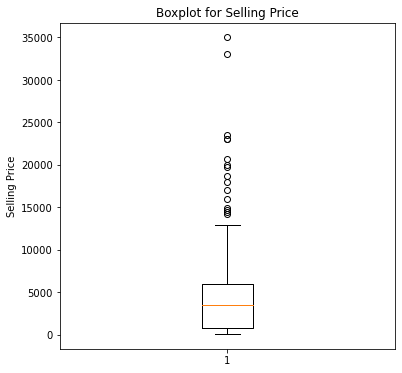

In [28]:
plt.figure(figsize=(6,6))

plt.boxplot(df['Selling_price_scale'])

plt.title('Boxplot for Selling Price')
plt.ylabel('Selling Price')

plt.show()

#### We can see that 2 selling prices are above 30,000 and may be outliers. Let's have a closer look at those 2 observations:

In [29]:
df[df['Selling_price_scale'] >= 30000]

Car_Name  Year  Selling_Price  Present_Price  Kms_Driven Fuel_Type  \
64      fortuner  2017           33.0          36.23        6000    Diesel   
86  land cruiser  2010           35.0          92.60       78000    Diesel   

   Seller_Type Transmission  Owner  Fuel_Type_CNG  ...  Fuel_Type_Petrol  \
64      Dealer    Automatic      0              0  ...                 0   
86      Dealer       Manual      0              0  ...                 0   

    Transmission_Automatic  Transmission_Manual  Seller_Type_Dealer  \
64                       1                    0                   1   
86                       0                    1                   1   

    Seller_Type_Individual  newer_old Newer  Old  Selling_price_scale  \
64                       0      Newer     1    0              33000.0   
86                       0        Old     0    1              35000.0   

    Present_price_scale  
64              36230.0  
86              92600.0  

[2 rows x 21 columns]

Although I'm no expert at cars, it may be possible that the newer fortuner 2017 with low kms sell at 33,000 used when a new price tag is 36,230. For that reason, I decided to keep that observation.

Also, the land cruiser selling at 35,000 is quite high but maybe not unrealistic since the kms is low and is known to be an expensive car. For that reason, I decided to also keep that observation.

In [30]:
df[df['Selling_price_scale'] <= 100]

Car_Name  Year  Selling_Price  Present_Price  Kms_Driven  \
200  Bajaj Pulsar 150  2006            0.1           0.75       92233   

    Fuel_Type Seller_Type Transmission  Owner  Fuel_Type_CNG  ...  \
200    Petrol  Individual       Manual      0              0  ...   

     Fuel_Type_Petrol  Transmission_Automatic  Transmission_Manual  \
200                 1                       0                    1   

     Seller_Type_Dealer  Seller_Type_Individual  newer_old Newer  Old  \
200                   0                       1        Old     0    1   

     Selling_price_scale  Present_price_scale  
200                100.0                750.0  

[1 rows x 21 columns]

Although the minimum selling price of 100 seems very low, the present price is 750 so it makes sense to keep that observation. 

### (iii) Plot histogram

In [31]:
plt.figure(figsize=(12,6))

plt.hist(df['Selling_price_scale'], bins=range(0,45000,5000), color='#52b2bf')

plt.title('Histogram for Selling Price')
plt.xlabel('Selling price')
plt.ylabel('Number of observations')

plt.show()

- Large skewness to the left
- Not normally distributed
- The vast majority of selling price for used cars is in the first bin from 0 to 5000

In [32]:
# Let's try to transform our data to get a normal distribution

pt = PowerTransformer()

print(pt.fit(df['Selling_price_scale'].values.reshape(-1,1)))

PowerTransformer()


In [33]:
df['Selling_price_scale_trans'] = pt.transform(df['Selling_price_scale'].values.reshape(-1,1))

In [34]:
df['Selling_price_scale_trans'].aggregate(['mean', 'std','median','min', 'max']).round(1)

mean     -0.0
std       1.0
median    0.2
min      -2.1
max       2.7
Name: Selling_price_scale_trans, dtype: float64

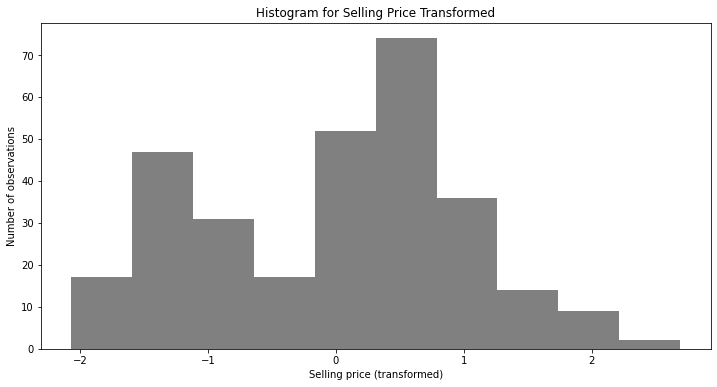

In [35]:
plt.figure(figsize=(12,6))

plt.hist(df['Selling_price_scale_trans'], color='grey')

plt.title('Histogram for Selling Price Transformed')
plt.xlabel('Selling price (transformed)')
plt.ylabel('Number of observations')

plt.show()

Selling price is still showing a not normal distribution so I decided to keep the original (not transformed) Selling price for my model.

## 2) Present_price_scale

### (i) Descriptive statistics

In [36]:
df['Present_price_scale'].aggregate(['mean', 'std','median','min', 'max']).round(1)

mean       7541.0
std        8567.9
median     6100.0
min         320.0
max       92600.0
Name: Present_price_scale, dtype: float64

- Very large distribution of present price because the std is again larger than the mean
- Min is 320 and max is 92,600. Does it make sense?

### (ii) Plot boxplot

In [37]:
plt.figure(figsize=(6,6))

plt.boxplot(df['Present_price_scale'])

plt.title('Boxplot for Present Price')
plt.ylabel('Present Price')

plt.show()

#### We can see that there is a present price that seems to be an outlier. Let's have a closer look at that particular observation:

In [38]:
df[df['Present_price_scale'] >= 80000]

Car_Name  Year  Selling_Price  Present_Price  Kms_Driven Fuel_Type  \
86  land cruiser  2010           35.0           92.6       78000    Diesel   

   Seller_Type Transmission  Owner  Fuel_Type_CNG  ...  \
86      Dealer       Manual      0              0  ...   

    Transmission_Automatic  Transmission_Manual  Seller_Type_Dealer  \
86                       0                    1                   1   

    Seller_Type_Individual  newer_old  Newer Old  Selling_price_scale  \
86                       0        Old      0   1              35000.0   

    Present_price_scale  Selling_price_scale_trans  
86              92600.0                   2.691976  

[1 rows x 22 columns]

I know that Land Cruiser is an expensive car, but if the 'Present_Price' is the price of the same car but new and that the average Present_Price for all cars is 7,541 then I highly doubt that the Land Cruiser is 12x more expensive than the average Present Price (price for the vehicle new). Afterall, it's not a Rolls Royce!

In addition, the difference between the selling price and the present price is very large with not much kms on the car. I believe that the present price was entered incorrectly in the database. For that reason, I decided to remove the observation:

In [39]:
df2 = df.drop(86, axis=0)
df2.shape

(298, 22)

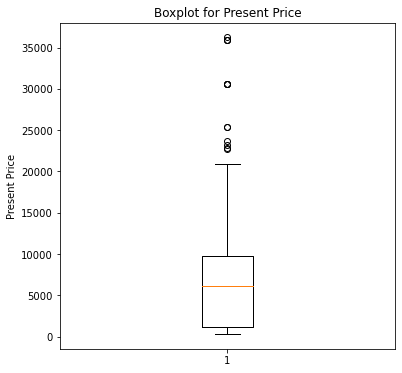

In [40]:
plt.figure(figsize=(6,6))

plt.boxplot(df2['Present_price_scale'])

plt.title('Boxplot for Present Price')
plt.ylabel('Present Price')

plt.show()

In [41]:
df2[df2['Present_price_scale'] >= 35000]

Car_Name  Year  Selling_Price  Present_Price  Kms_Driven Fuel_Type  \
59  fortuner  2014          19.99          35.96       41000    Diesel   
62  fortuner  2014          18.75          35.96       78000    Diesel   
63  fortuner  2015          23.50          35.96       47000    Diesel   
64  fortuner  2017          33.00          36.23        6000    Diesel   

   Seller_Type Transmission  Owner  Fuel_Type_CNG  ...  \
59      Dealer    Automatic      0              0  ...   
62      Dealer    Automatic      0              0  ...   
63      Dealer    Automatic      0              0  ...   
64      Dealer    Automatic      0              0  ...   

    Transmission_Automatic  Transmission_Manual  Seller_Type_Dealer  \
59                       1                    0                   1   
62                       1                    0                   1   
63                       1                    0                   1   
64                       1                    0                   1   

    Seller_Type_Individual  newer_old  Newer Old  Selling_price_scale  \
59                       0        Old      0   1              19990.0   
62                       0        Old      0   1              18750.0   
63                       0        Old      0   1              23500.0   
64                       0      Newer      1   0              33000.0   

    Present_price_scale  Selling_price_scale_trans  
59              35960.0                   1.974540  
62              35960.0                   1.897294  
63              35960.0                   2.173929  
64              36230.0                   2.612954  

[4 rows x 22 columns]

Since all Fortuner seem to be around the same present price, it proves that these are not outliers but real prices.

### (iii) Plot histogram

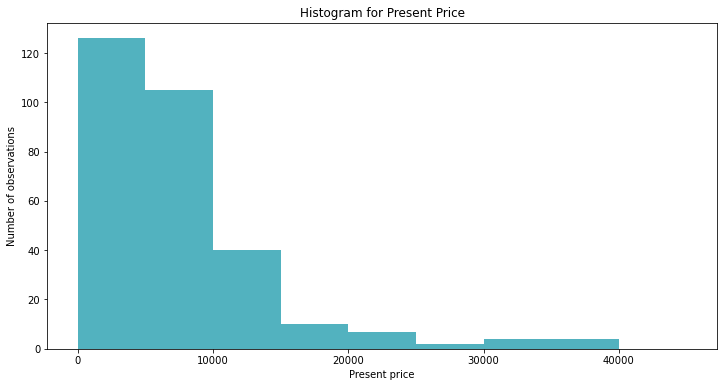

In [42]:
plt.figure(figsize=(12,6))

plt.hist(df2['Present_price_scale'], bins=range(0,50000,5000), color='#52b2bf')

plt.title('Histogram for Present Price')
plt.xlabel('Present price')
plt.ylabel('Number of observations')

plt.show()

- Large skewness to the left
- Not normally distributed
- The vast majority of present price is in the first two bins from 0 to 10,000

In [43]:
# Let's try to transform our data to get a normal distribution

print(pt.fit(df['Present_price_scale'].values.reshape(-1,1)))

PowerTransformer()


In [44]:
df['Present_price_scale_trans'] = pt.transform(df['Present_price_scale'].values.reshape(-1,1))

In [45]:
df['Present_price_scale_trans'].aggregate(['mean', 'std','median','min', 'max']).round(1)

mean      0.0
std       1.0
median    0.2
min      -1.8
max       3.3
Name: Present_price_scale_trans, dtype: float64

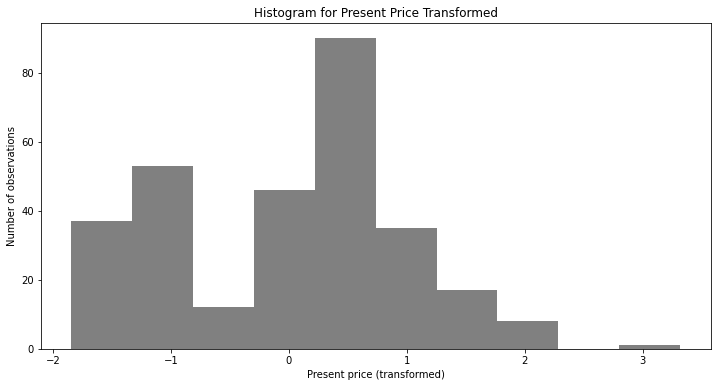

In [46]:
plt.figure(figsize=(12,6))

plt.hist(df['Present_price_scale_trans'], color='grey')

plt.title('Histogram for Present Price Transformed')
plt.xlabel('Present price (transformed)')
plt.ylabel('Number of observations')

plt.show()

Again, Present price is still showing a not normal distribution so I decided to keep the original (not transformed) Present price for my model.

## 3) Kms_Driven

### (i) Descriptive statistics

In [47]:
df2['Kms_Driven'].aggregate(['mean', 'std','median','min', 'max']).round(1)

mean       36778.9
std        39007.8
median     31802.0
min          500.0
max       500000.0
Name: Kms_Driven, dtype: float64

- Very large distribution of kms driven because the std is again larger than the mean
- Min is 500 and max is 500,000. Does it make sense?

### (ii) Plot boxplot

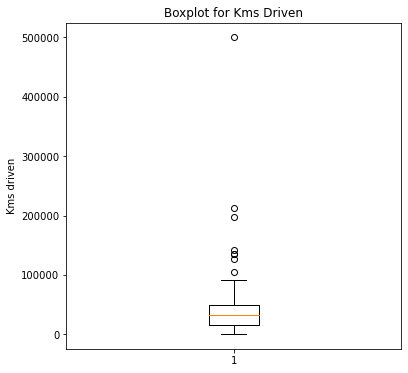

In [48]:
plt.figure(figsize=(6,6))

plt.boxplot(df2['Kms_Driven'])

plt.title('Boxplot for Kms Driven')
plt.ylabel('Kms driven')

plt.show()

#### We can see that there are a few dots that seem to be outliers, especially the one over 300,000 km. Let's have a closer look at that particular observation:

In [49]:
df2[df2['Kms_Driven'] >= 300000]

Car_Name  Year  Selling_Price  Present_Price  Kms_Driven Fuel_Type  \
196  Activa 3g  2008           0.17           0.52      500000    Petrol   

    Seller_Type Transmission  Owner  Fuel_Type_CNG  ...  \
196  Individual    Automatic      0              0  ...   

     Transmission_Automatic  Transmission_Manual  Seller_Type_Dealer  \
196                       1                    0                   0   

     Seller_Type_Individual  newer_old  Newer Old  Selling_price_scale  \
196                       1        Old      0   1                170.0   

     Present_price_scale  Selling_price_scale_trans  
196                520.0                  -1.821971  

[1 rows x 22 columns]

I read on the internet that fewer than 1% of cars make it to the 200,000-mile mark which is equivalent to 320,000 kms. Based on that, I consider that a car with 500,000 kms is probably an outlier and should be deleted:

In [50]:
df2 = df2.drop(196, axis=0)
df2.shape

(297, 22)

### (iii) Plot histogram

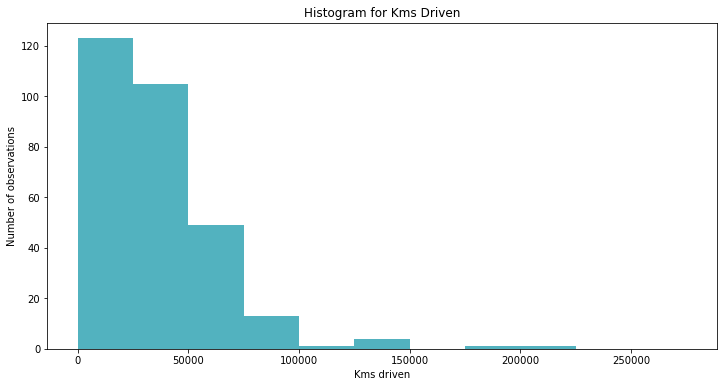

In [51]:
plt.figure(figsize=(12,6))

plt.hist(df2['Kms_Driven'], bins=range(0,300000,25000), color='#52b2bf')

plt.title('Histogram for Kms Driven')
plt.xlabel('Kms driven')
plt.ylabel('Number of observations')

plt.show()

- Large skewness to the left
- Not normally distributed
- The vast majority of kms driven are in the first 2 bins, that is between 0 and 50,000

In [52]:
# Let's try to transform our data to get a normal distribution

print(pt.fit(df['Kms_Driven'].values.reshape(-1,1)))

PowerTransformer()


In [53]:
df['Kms_Driven_trans'] = pt.transform(df['Kms_Driven'].values.reshape(-1,1))

In [54]:
df['Kms_Driven_trans'].aggregate(['mean', 'std','median','min', 'max']).round(1)

mean     -0.0
std       1.0
median    0.1
min      -2.7
max       4.8
Name: Kms_Driven_trans, dtype: float64

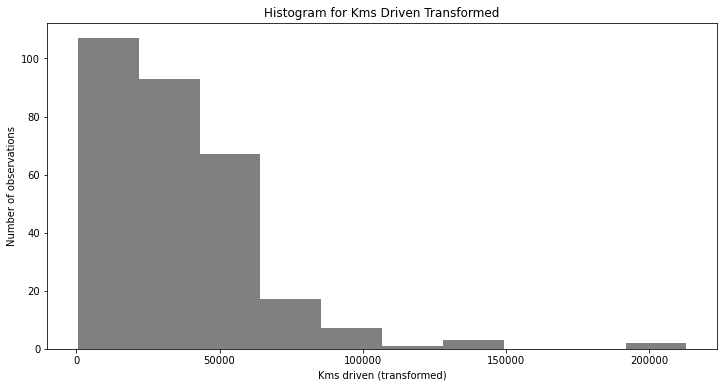

In [55]:
plt.figure(figsize=(12,6))

plt.hist(df2['Kms_Driven'], color='grey')

plt.title('Histogram for Kms Driven Transformed')
plt.xlabel('Kms driven (transformed)')
plt.ylabel('Number of observations')

plt.show()

Again, Kms driven is still showing a not normal distribution so I decided to keep the original (not transformed) Kms driven for my model.

## 4) Owner

### (i) Descriptive statistics

In [56]:
df2['Owner'].aggregate(['mean', 'std','median','min', 'max']).round(1)

mean      0.0
std       0.2
median    0.0
min       0.0
max       3.0
Name: Owner, dtype: float64

- Looking at the mean doesn't make sense for this variable, but we can see that the minimum owner is 0 and the maximum is 3.

### (ii) Plot boxplot

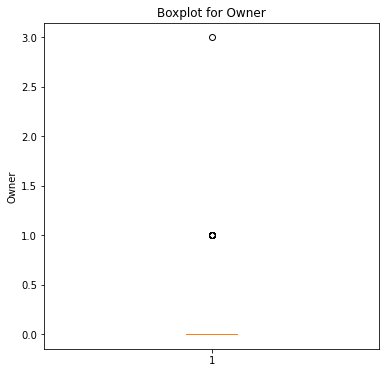

In [57]:
plt.figure(figsize=(6,6))

plt.boxplot(df2['Owner'])

plt.title('Boxplot for Owner')
plt.ylabel('Owner')

plt.show()

- It doesn't make sense in this case to look at the boxplot because we know that owner == 1 or owner == 3 are not outliers

### (iii) Plot histogram

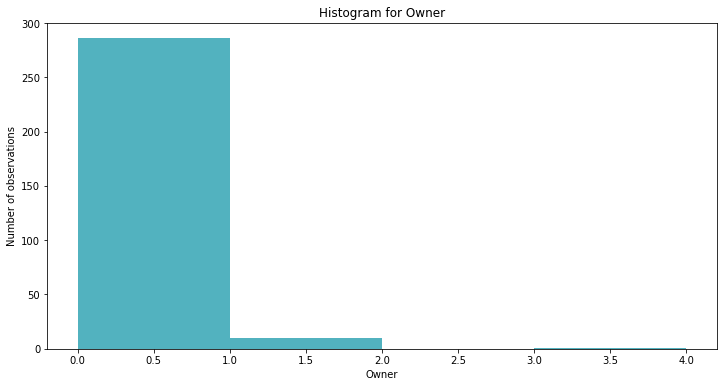

In [58]:
plt.figure(figsize=(12,6))

plt.hist(df2['Owner'], bins=[0,1,2,3,4], color='#52b2bf')

plt.title('Histogram for Owner')
plt.xlabel('Owner')
plt.ylabel('Number of observations')

plt.show()

- Indeed, no car had 2 owners
- Almost all cars had 0 owner, 10 cars had 1 owner and 1 car had 3 owners. 
- A possible explanation for the high number of cars with no owner was that those cars were leased.

- Looking at the histogram, there is a very large skewness to the left
- Not normally distributed
- As mentioned above, the vast majority of owner is equal to 0.

## 5) Year

### (i) Descriptive statistics

In [59]:
df2['Year'].aggregate(['mean', 'std','median','min', 'max']).round(1)

mean      2013.6
std          2.9
median    2014.0
min       2003.0
max       2018.0
Name: Year, dtype: float64

- Small distribution due to a small std
- Min is year 2003 and max is year 2018 which makes sense.

### (ii) Plot boxplot

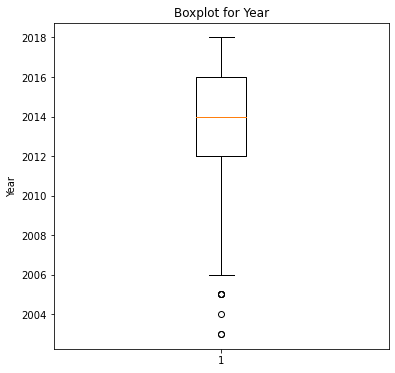

In [60]:
plt.figure(figsize=(6,6))

plt.boxplot(df2['Year'])

plt.title('Boxplot for Year')
plt.ylabel('Year')

plt.show()

We can see that there are a few dots that seem to be outliers, however, having used cars for sale in the year 2003, 2004, and 2005 is totally possible. Therefore, I decided not to remove any observation. 

### (iii) Plot histogram

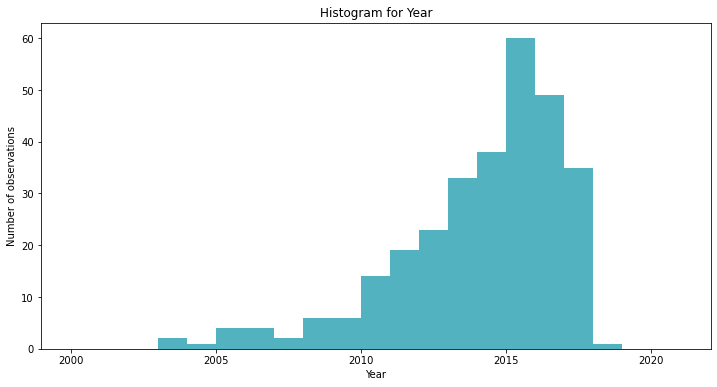

In [61]:
plt.figure(figsize=(12,6))

plt.hist(df2['Year'], bins=range(2000,2022,1), color='#52b2bf')

plt.title('Histogram for Year')
plt.xlabel('Year')
plt.ylabel('Number of observations')

plt.show()

- Large skewness to the right
- Not normally distributed
- The highest numbers of cars for sale were manufactured in 2015

## Bi-variate analysis for numetic data combinations

In [62]:
# Let's create a smaller DF (df3) with only numeric variables

df3 = df2[['Selling_price_scale', 'Present_price_scale', 'Kms_Driven', 'Owner', 'Year']]
df3.head(2)

Selling_price_scale  Present_price_scale  Kms_Driven  Owner  Year
0               3350.0               5590.0       27000      0  2014
1               4750.0               9540.0       43000      0  2013

### 1) Correlation Coefficients

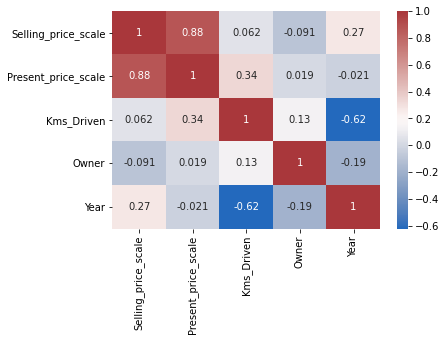

In [63]:
# Calculate correlation coefficients

sns.heatmap(df3.corr(),annot=True,cmap=sns.cm.vlag)
plt.show()

It looks like selling price and present price seem to be strongly and positively correlated at 0.88. 
There is also a weak but positive correlation between selling price and Year (0.27).

Note: there is no correlation coefficient >0.70 between independent numeric variables meaning no multicollinearity.

### 2) Pairplot

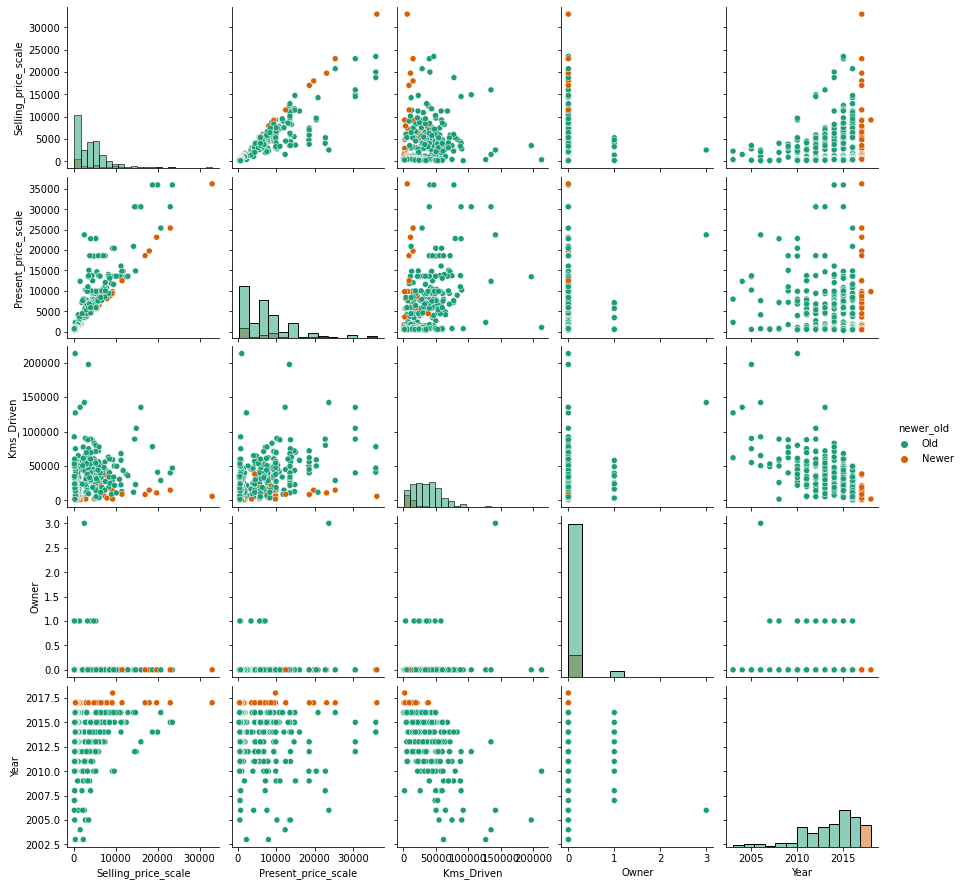

In [64]:
# Let's look at a pairplot to visualize correlations

sns.pairplot(data=df2[['Selling_price_scale', 'Present_price_scale', 'Kms_Driven', 'Owner', 'Year', 'newer_old']], 
             hue ='newer_old', hue_order = ['Old', 'Newer'], palette='Dark2', diag_kind = 'hist')
plt.show()

#### Again, only selling price and present price seem to have a strong visual correlation and the correlation is positive. 

Note: there is a potential multicollinearity between newer_old and year and kms driven. I'll verify later with correlation coefficients.

### 3) Scatterplots

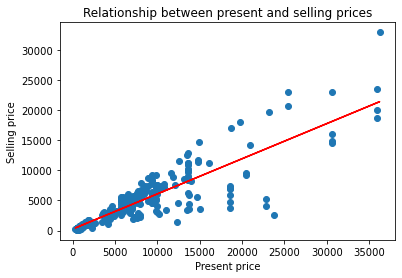

Intercept:  [242.24518493]
Slope:  [[0.58528586]]
R2 score:  0.773083512283244


In [65]:
#We can use a scatterplot to confirm that a relationship exists between present price & selling price

x=df3['Present_price_scale']
y=df3['Selling_price_scale']

plt.scatter(x, y)
plt.title('Relationship between present and selling prices')
plt.xlabel('Present price')
plt.ylabel('Selling price')

x=x.values.reshape(-1,1)
y=y.values.reshape(-1,1)
lr=LinearRegression()
lr.fit(x,y)
y_pred=lr.predict(x)
r2 = r2_score(y,y_pred)
plt.plot(x,y_pred, color='red')

plt.show()

print('Intercept: ', lr.intercept_)
print('Slope: ', lr.coef_)
print('R2 score: ', r2)

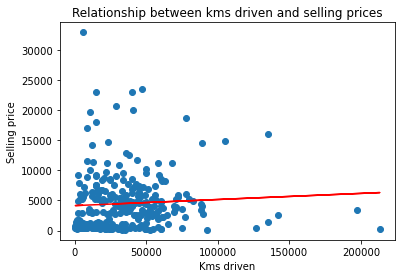

Intercept:  [4143.62860645]
Slope:  [[0.01017889]]
R2 score:  0.003797136312342353


In [66]:
#We can use a scatterplot to confirm that a relationship does not exist between kms driven & selling price

x=df3['Kms_Driven']
y=df3['Selling_price_scale']

plt.scatter(x, y)
plt.title('Relationship between kms driven and selling prices')
plt.xlabel('Kms driven')
plt.ylabel('Selling price')

x=x.values.reshape(-1,1)
y=y.values.reshape(-1,1)
lr=LinearRegression()
lr.fit(x,y)
y_pred=lr.predict(x)
r2 = r2_score(y,y_pred)
plt.plot(x,y_pred, color='red')

plt.show()

print('Intercept: ', lr.intercept_)
print('Slope: ', lr.coef_)
print('R2 score: ', r2)

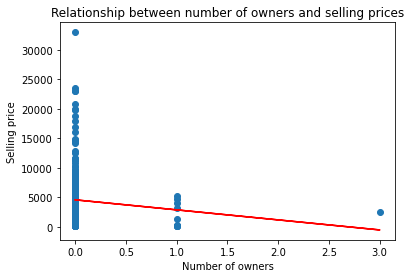

Intercept:  [4576.51991231]
Slope:  [[-1699.72415053]]
R2 score:  0.008247216490512299


In [67]:
#We can use a scatterplot to confirm that a relationship does not exist between owner & selling price

x=df3['Owner']
y=df3['Selling_price_scale']

plt.scatter(x, y)
plt.title('Relationship between number of owners and selling prices')
plt.xlabel('Number of owners')
plt.ylabel('Selling price')

x=x.values.reshape(-1,1)
y=y.values.reshape(-1,1)
lr=LinearRegression()
lr.fit(x,y)
y_pred=lr.predict(x)
r2 = r2_score(y,y_pred)
plt.plot(x,y_pred, color='red')

plt.show()

print('Intercept: ', lr.intercept_)
print('Slope: ', lr.coef_)
print('R2 score: ', r2)

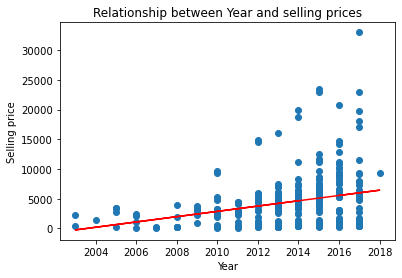

Intercept:  [-892797.71609661]
Slope:  [[445.60942204]]
R2 score:  0.0755297103303918


In [68]:
#We can use a scatterplot to confirm that a relationship is weak between Year & selling price
  
x=df3['Year']
y=df3['Selling_price_scale']    
    
plt.scatter(x, y)

plt.title('Relationship between Year and selling prices')
plt.xlabel('Year')
plt.ylabel('Selling price')

x=x.values.reshape(-1,1)
y=y.values.reshape(-1,1)
lr=LinearRegression()
lr.fit(x,y)
y_pred=lr.predict(x)
r2 = r2_score(y,y_pred)
plt.plot(x,y_pred, color='red')

plt.show()

print('Intercept: ', lr.intercept_)
print('Slope: ', lr.coef_)
print('R2 score: ', r2)

## Bi-variate analysis for numetic and categorical data combinations

## 1) Correlation Coefficients

<AxesSubplot:>

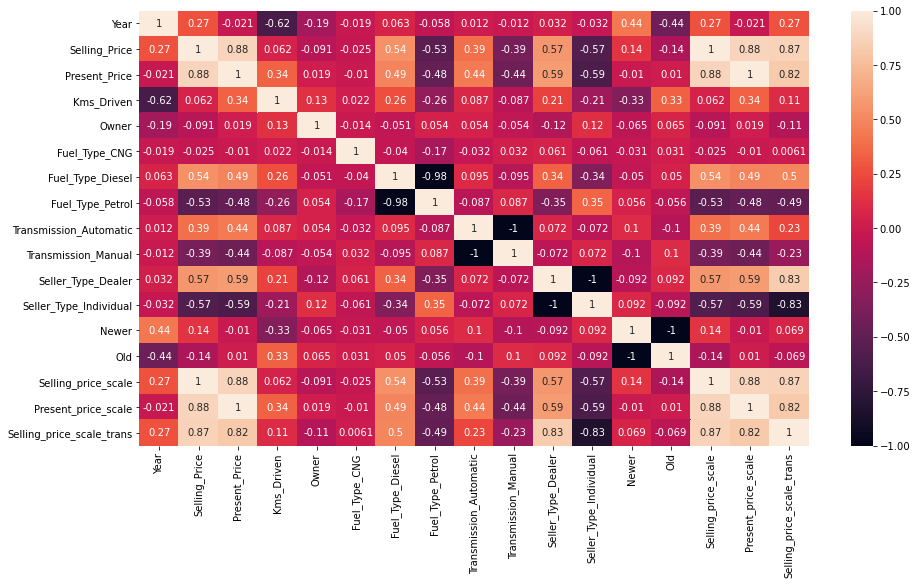

In [69]:
fig,ax1 = plt.subplots(figsize=(15,8))
sns.heatmap(df2.corr(),annot=True,ax=ax1,cmap='rocket')

#### The correlation coefficient between newer and year is 0.44 and between newer and kms driven is -0.33.
#### Since both are <|0.70|, it does not suggest a multicollinearity between those independent variables.

## 2) Groupby categorical variables and calculate corresponding stats

### (i) Selling price and Fuel type

In [70]:
df2.groupby(['Fuel_Type'])[['Selling_price_scale']].aggregate(['mean', 'std','median','min', 'max', 'count'])

Selling_price_scale                                            
                         mean          std  median     min      max count
Fuel_Type                                                                
CNG               3100.000000   212.132034  3100.0  2950.0   3250.0     2
Diesel            9665.964912  6331.885823  7450.0  3100.0  33000.0    57
Petrol            3277.184874  3135.683435  2675.0   100.0  19750.0   238

On average, it looks like the diesel cars have a much higher selling price than the others. 

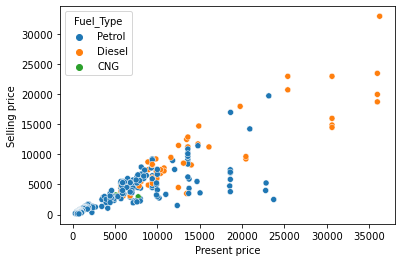

In [71]:
sns.scatterplot(x='Present_price_scale', y='Selling_price_scale', data=df2, hue='Fuel_Type')

plt.xlabel('Present price')
plt.ylabel('Selling price')

plt.show()

It also looks like the most expensive cars are diesel.

### (ii) Selling price and Seller type

In [72]:
df2.groupby(['Seller_Type'])[['Selling_price_scale']].aggregate(['mean', 'std','median','min', 'max','count'])

Selling_price_scale                                            
                           mean          std  median     min      max count
Seller_Type                                                                
Dealer              6484.270833  4599.725406  5250.0  1050.0  33000.0   192
Individual           877.619048  1645.781042   520.0   100.0  16000.0   105

On average, it looks like the cars for sale by a dealer have a much higher selling price than those for sale by individuals.

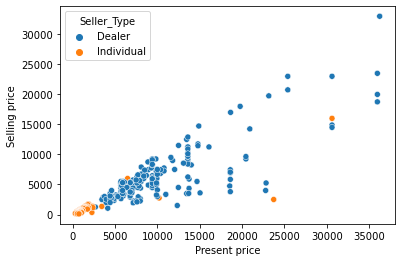

In [73]:
sns.scatterplot(x='Present_price_scale', y='Selling_price_scale', data=df2, hue='Seller_Type')

plt.xlabel('Present price')
plt.ylabel('Selling price')

plt.show()

It looks like the majority of cars for sale individually have a much lower selling price. 

### (iii) Selling price and Transmission

In [74]:
df2.groupby(['Transmission'])[['Selling_price_scale']].aggregate(['mean', 'std','median','min', 'max','count'])

Selling_price_scale                                           
                            mean          std  median    min      max count
Transmission                                                               
Automatic            9306.052632  8581.108584  5800.0  250.0  33000.0    38
Manual               3797.297297  3250.747981  3250.0  100.0  17000.0   259

On average, it looks like the automatic transmission cars are selling at a much higher price than the manual transmission cars.

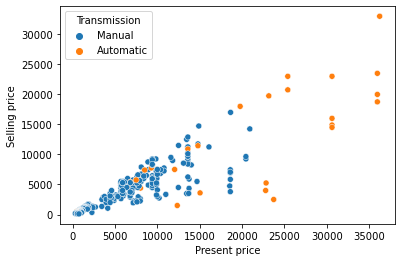

In [75]:
sns.scatterplot(x='Present_price_scale', y='Selling_price_scale', data=df2, hue='Transmission')

plt.xlabel('Present price')
plt.ylabel('Selling price')

plt.show()

It looks like the most expensive cars are all automatic.

### (iv) Selling price and Newer_old

In [76]:
df2.groupby(['newer_old'])[['Selling_price_scale']].aggregate(['mean', 'std','median','min', 'max','count'])

Selling_price_scale                                           
                         mean          std  median    min      max count
newer_old                                                               
Newer             6293.611111  7518.118364  4150.0  400.0  33000.0    36
Old               4255.019157  4088.802874  3510.0  100.0  23500.0   261

On average, it looks like newer cars are selling at a higher price than older cars.

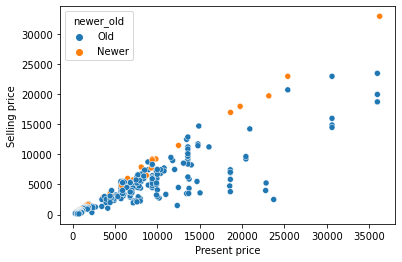

In [77]:
sns.scatterplot(x='Present_price_scale', y='Selling_price_scale', data=df2, hue='newer_old')

plt.xlabel('Present price')
plt.ylabel('Selling price')

plt.show()

However, from the graph, it does not look like the majority of newer cars are getting sold at a higher price than old cars. Both categories are spread out from low to high selling prices.

### Overall, the highest selling price for cars seems to be those with: 
    (i) diesel
    (ii) for sale by dealers
    (iii) automatic transmission
    (iv) have a higher present price 
    (v) manufactured in recent years (to some extent)

# State a hypothesis which you can test with a regression model.

### Hypothesis: based on the exploratory analysis done previously, my prediction is that selling price is based on:
    - present price
    - year
    - fuel type
    - seller type
    - transmission

# Build a linear regression model based on your hypothesis. 

In [78]:
df2.columns

Index(['Car_Name', 'Year', 'Selling_Price', 'Present_Price', 'Kms_Driven',
       'Fuel_Type', 'Seller_Type', 'Transmission', 'Owner', 'Fuel_Type_CNG',
       'Fuel_Type_Diesel', 'Fuel_Type_Petrol', 'Transmission_Automatic',
       'Transmission_Manual', 'Seller_Type_Dealer', 'Seller_Type_Individual',
       'newer_old', 'Newer', 'Old', 'Selling_price_scale',
       'Present_price_scale', 'Selling_price_scale_trans'],
      dtype='object')

In [79]:
# Need to convert the Owner into dummies

df['Owner'].unique()

array([0, 1, 3])

In [80]:
Owner_dummy = pd.get_dummies(df2['Owner'])
Owner_dummy.rename(columns={0:'No_owner',1:'One_owner',3:'Three_owners'}, inplace=True)

In [81]:
df2 = pd.concat([df2,Owner_dummy],axis=1)
df2.columns

Index(['Car_Name', 'Year', 'Selling_Price', 'Present_Price', 'Kms_Driven',
       'Fuel_Type', 'Seller_Type', 'Transmission', 'Owner', 'Fuel_Type_CNG',
       'Fuel_Type_Diesel', 'Fuel_Type_Petrol', 'Transmission_Automatic',
       'Transmission_Manual', 'Seller_Type_Dealer', 'Seller_Type_Individual',
       'newer_old', 'Newer', 'Old', 'Selling_price_scale',
       'Present_price_scale', 'Selling_price_scale_trans', 'No_owner',
       'One_owner', 'Three_owners'],
      dtype='object')

#### It seems like we have created all dummies needed for the model (fuel type, seller type, transmission, owner, newer_old).

## Let's start to build the first model with testing the variables included in the hypothesis:

In [82]:
# Model_hypothesis: selling price vs
            
            # seller type (ref=individual)
            # transmission (ref=manual)
            # fuel type (ref=petrol)
            # present price
            # year
    
resultsHyp=ols("Selling_price_scale ~ C(Seller_Type, Treatment(reference='Individual')) + C(Transmission, Treatment(reference='Manual')) + C(Fuel_Type, Treatment(reference='Petrol')) + Present_price_scale + Year", data=df2).fit()
print(resultsHyp.summary())

                             OLS Regression Results                            
Dep. Variable:     Selling_price_scale   R-squared:                       0.872
Model:                             OLS   Adj. R-squared:                  0.870
Method:                  Least Squares   F-statistic:                     330.4
Date:                 Fri, 23 Apr 2021   Prob (F-statistic):          1.88e-126
Time:                         11:38:26   Log-Likelihood:                -2624.6
No. Observations:                  297   AIC:                             5263.
Df Residuals:                      290   BIC:                             5289.
Df Model:                            6                                         
Covariance Type:             nonrobust                                         
                                                                  coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

#### Model hypothesis reveals a R2 of 0.872 and adj R2 of 0.870 which is really good. 

        Model hypothesis shows two variables with p-value >0.05 (transmission and fuel type)

## Let's try now to build a better model by adding all independent variables:

In [83]:
# Model #1: selling price vs all independent variables:
                      
            # transmission (ref=Manual)
            # seller type (ref=Individual)
            # newer_old (ref=Old)
            # owner (ref=3 owners)
            # fuel type (ref=Diesel)
            # present price
            # year
            # kms driven

results1=ols("Selling_price_scale ~  C(Transmission, Treatment(reference='Manual')) + C(Seller_Type, Treatment(reference='Individual')) + C(newer_old, Treatment(reference='Old')) + C(Owner, Treatment(reference=3)) + C(Fuel_Type, Treatment(reference='Diesel')) + Present_price_scale + Year + Kms_Driven", data=df2).fit()
print(results1.summary())

                             OLS Regression Results                            
Dep. Variable:     Selling_price_scale   R-squared:                       0.891
Model:                             OLS   Adj. R-squared:                  0.887
Method:                  Least Squares   F-statistic:                     233.8
Date:                 Fri, 23 Apr 2021   Prob (F-statistic):          2.70e-131
Time:                         11:38:26   Log-Likelihood:                -2601.2
No. Observations:                  297   AIC:                             5224.
Df Residuals:                      286   BIC:                             5265.
Df Model:                           10                                         
Covariance Type:             nonrobust                                         
                                                                  coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

#### Model #1 reveals a R2 of 0.891 and adj R2 of 0.887 which is better than the hypothesis model.

    Model #1 shows three variables with p-value >0.05

## Let's try to remove one variable (p-value >0.05) at a time starting with Transmission that has the highest p-value

In [84]:
# Model #2: selling price vs (all independent variables - Transmission):

            # seller type (ref=Individual)
            # newer_old (ref=Old)
            # owner (ref=3 owners)
            # fuel type (ref=Diesel)
            # present price
            # year
            # kms driven

results2=ols("Selling_price_scale ~  C(Seller_Type, Treatment(reference='Individual')) + C(newer_old, Treatment(reference='Old')) + C(Owner, Treatment(reference=3)) + C(Fuel_Type, Treatment(reference='Diesel')) + Present_price_scale + Year + Kms_Driven", data=df2).fit()
print(results2.summary())

                             OLS Regression Results                            
Dep. Variable:     Selling_price_scale   R-squared:                       0.890
Model:                             OLS   Adj. R-squared:                  0.887
Method:                  Least Squares   F-statistic:                     258.5
Date:                 Fri, 23 Apr 2021   Prob (F-statistic):          4.70e-132
Time:                         11:38:27   Log-Likelihood:                -2602.3
No. Observations:                  297   AIC:                             5225.
Df Residuals:                      287   BIC:                             5261.
Df Model:                            9                                         
Covariance Type:             nonrobust                                         
                                                                  coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

#### Model #2 reveals a R2 of 0.890 and adj R2 of 0.887 which is not better than Model #1.

    Model #2 shows three variables with p-value >0.05 (seller type, newer_old, and fuel type)

## Let's now remove the Seller Type

In [85]:
# Model #3: selling price vs (all independent variables - Transmission - Seller type):

            # newer_old (ref=Old)
            # owner (ref=3 owners)
            # fuel type (ref=Diesel)
            # present price
            # year
            # kms driven

results3=ols("Selling_price_scale ~  C(newer_old, Treatment(reference='Old')) + C(Owner, Treatment(reference=3)) + C(Fuel_Type, Treatment(reference='Diesel')) + Present_price_scale + Year + Kms_Driven", data=df2).fit()
print(results3.summary())

                             OLS Regression Results                            
Dep. Variable:     Selling_price_scale   R-squared:                       0.889
Model:                             OLS   Adj. R-squared:                  0.886
Method:                  Least Squares   F-statistic:                     287.7
Date:                 Fri, 23 Apr 2021   Prob (F-statistic):          1.64e-132
Time:                         11:38:27   Log-Likelihood:                -2604.1
No. Observations:                  297   AIC:                             5226.
Df Residuals:                      288   BIC:                             5260.
Df Model:                            8                                         
Covariance Type:             nonrobust                                         
                                                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

#### Model #3 reveals a R2 of 0.889 and adj R2 of 0.886 which is not better than Model #1.

    Model #3 shows two variables with p-value >0.05 (newer_old and fuel type)

## Let's remove Newer_old

In [86]:
# Model #4: selling price vs (all independent variables - Transmission - Seller type - Newer_old):
            
            # owner (ref=3 owners)
            # fuel type (ref=Diesel)
            # present price
            # year
            # kms driven

results4=ols("Selling_price_scale ~ C(Owner, Treatment(reference=3)) + C(Fuel_Type, Treatment(reference='Diesel')) + Present_price_scale + Year + Kms_Driven ", data=df2).fit()
print(results4.summary())

                             OLS Regression Results                            
Dep. Variable:     Selling_price_scale   R-squared:                       0.888
Model:                             OLS   Adj. R-squared:                  0.885
Method:                  Least Squares   F-statistic:                     326.2
Date:                 Fri, 23 Apr 2021   Prob (F-statistic):          3.64e-133
Time:                         11:38:27   Log-Likelihood:                -2605.6
No. Observations:                  297   AIC:                             5227.
Df Residuals:                      289   BIC:                             5257.
Df Model:                            7                                         
Covariance Type:             nonrobust                                         
                                                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

#### Model #4 reveals a R2 of 0.888 and adj R2 of 0.885 which is not better than Model #1.

    Model #4 shows one variable with p-value >0.05 (fuel type)

## Finally, let's deal with the Fuel Type dummy. 
### Model #4 includes the fuel type dummy but one of the categories is not statistically significant (CNG) and the other one is (Petrol). 
### Let's compare Model #4 (including the fuel type dummy) with Model #5 below (excluding the fuel type dummy). 

In [87]:
# Model #5: selling price vs (all independent variables - Transmission - Seller type - Newer_old - Fuel type):
            
            # owner (ref=3 owners)
            # present price
            # year
            # kms driven
           
results5=ols("Selling_price_scale ~ C(Owner, Treatment(reference=3)) + Present_price_scale + Year + Kms_Driven ", data=df2).fit()
print(results5.summary())

                             OLS Regression Results                            
Dep. Variable:     Selling_price_scale   R-squared:                       0.875
Model:                             OLS   Adj. R-squared:                  0.873
Method:                  Least Squares   F-statistic:                     407.8
Date:                 Fri, 23 Apr 2021   Prob (F-statistic):          3.90e-129
Time:                         11:38:27   Log-Likelihood:                -2621.4
No. Observations:                  297   AIC:                             5255.
Df Residuals:                      291   BIC:                             5277.
Df Model:                            5                                         
Covariance Type:             nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

### Although Model #5 shows no variable with p-value >0.05, it reveals a R2 of 0.875 and adj R2 of 0.873 which is much lower than Model #4. 
### As a result, I consider Model #4 being the best model so far because it only has one dummy variable (fuel type CNG) with a p-value>0.05 as compared to Model #1 which has three. 

## The only variable that I have not considered yet is the Car_Name. So, I would like to break it down into categories and see if it could improve Model #4.

In [88]:
df2['Car_Name'].unique()

array(['ritz', 'sx4', 'ciaz', 'wagon r', 'swift', 'vitara brezza',
       's cross', 'alto 800', 'ertiga', 'dzire', 'alto k10', 'ignis',
       '800', 'baleno', 'omni', 'fortuner', 'innova', 'corolla altis',
       'etios cross', 'etios g', 'etios liva', 'corolla', 'etios gd',
       'camry', 'Royal Enfield Thunder 500', 'UM Renegade Mojave',
       'KTM RC200', 'Bajaj Dominar 400', 'Royal Enfield Classic 350',
       'KTM RC390', 'Hyosung GT250R', 'Royal Enfield Thunder 350',
       'KTM 390 Duke ', 'Mahindra Mojo XT300', 'Bajaj Pulsar RS200',
       'Royal Enfield Bullet 350', 'Royal Enfield Classic 500',
       'Bajaj Avenger 220', 'Bajaj Avenger 150', 'Honda CB Hornet 160R',
       'Yamaha FZ S V 2.0', 'Yamaha FZ 16', 'TVS Apache RTR 160',
       'Bajaj Pulsar 150', 'Honda CBR 150', 'Hero Extreme',
       'Bajaj Avenger 220 dtsi', 'Bajaj Avenger 150 street',
       'Yamaha FZ  v 2.0', 'Bajaj Pulsar  NS 200', 'Bajaj Pulsar 220 F',
       'TVS Apache RTR 180', 'Hero Passion X pro', '

In [89]:
df2.groupby(df2['Car_Name'])[['Selling_price_scale']].count().sort_values(['Selling_price_scale'], ascending=False)

Selling_price_scale
Car_Name                                   
city                                     26
corolla altis                            16
verna                                    14
brio                                     10
fortuner                                 10
...                                     ...
Hero Hunk                                 1
camry                                     1
Hero Honda Passion Pro                    1
Hero Honda CBZ extreme                    1
800                                       1

[97 rows x 1 columns]

In [90]:
# Create a new column

df2['Car_Type'] = df2['Car_Name']

In [91]:
# Create categories

df2.loc[df2['Car_Type'].str.contains(r'city', case=False, na=False), 'Car_Type'] = 'City'
df2.loc[df2['Car_Type'].str.contains(r'corolla', case=False, na=False), 'Car_Type'] = 'Corolla'
df2.loc[df2['Car_Type'].str.contains(r'fortuner', case=False, na=False), 'Car_Type'] = 'Fortuner'

In [92]:
df2['Car_Type'] = df2['Car_Type'].replace(list(df2['Car_Type'].loc[
        (df2['Car_Type'] != 'City')&
        (df2['Car_Type'] != 'Corolla')&
        (df2['Car_Type'] != 'Fortuner')]), 'Other')

In [93]:
df2.head(2)

Car_Name  Year  Selling_Price  Present_Price  Kms_Driven Fuel_Type  \
0     ritz  2014           3.35           5.59       27000    Petrol   
1      sx4  2013           4.75           9.54       43000    Diesel   

  Seller_Type Transmission  Owner  Fuel_Type_CNG  ...  newer_old  Newer  Old  \
0      Dealer       Manual      0              0  ...        Old      0    1   
1      Dealer       Manual      0              0  ...        Old      0    1   

   Selling_price_scale  Present_price_scale  Selling_price_scale_trans  \
0               3350.0               5590.0                   0.137625   
1               4750.0               9540.0                   0.449218   

  No_owner  One_owner  Three_owners  Car_Type  
0        1          0             0     Other  
1        1          0             0     Other  

[2 rows x 26 columns]

In [94]:
df2.groupby(['Car_Type'])[['Selling_price_scale']].aggregate(['mean', 'count'])

Selling_price_scale      
                        mean count
Car_Type                          
City             7419.230769    26
Corolla          6848.823529    17
Fortuner        18254.000000    10
Other            3464.180328   244

In [95]:
# Create dummy variables

car_type_dummy = pd.get_dummies(df2['Car_Type'])

In [96]:
df2 = pd.concat([df2,car_type_dummy],axis=1)
df2.columns

Index(['Car_Name', 'Year', 'Selling_Price', 'Present_Price', 'Kms_Driven',
       'Fuel_Type', 'Seller_Type', 'Transmission', 'Owner', 'Fuel_Type_CNG',
       'Fuel_Type_Diesel', 'Fuel_Type_Petrol', 'Transmission_Automatic',
       'Transmission_Manual', 'Seller_Type_Dealer', 'Seller_Type_Individual',
       'newer_old', 'Newer', 'Old', 'Selling_price_scale',
       'Present_price_scale', 'Selling_price_scale_trans', 'No_owner',
       'One_owner', 'Three_owners', 'Car_Type', 'City', 'Corolla', 'Fortuner',
       'Other'],
      dtype='object')

## Let's enter the car type dummy variables into Model #4

In [97]:
# Model #6: Model #4 + car type dummy variables:

            # owner (ref=3 owners)
            # fuel_type (ref=Diesel)
            # car type dummy variables (ref=Other)
            # present price
            # year
            # kms driven

results6=ols("Selling_price_scale ~  C(Owner, Treatment(reference=3)) + C(Fuel_Type, Treatment(reference='Diesel')) + C(Car_Type, Treatment(reference='Other')) + Present_price_scale + Year + Kms_Driven", data=df2).fit()
print(results6.summary())

                             OLS Regression Results                            
Dep. Variable:     Selling_price_scale   R-squared:                       0.913
Model:                             OLS   Adj. R-squared:                  0.910
Method:                  Least Squares   F-statistic:                     301.3
Date:                 Fri, 23 Apr 2021   Prob (F-statistic):          1.80e-145
Time:                         11:38:27   Log-Likelihood:                -2567.2
No. Observations:                  297   AIC:                             5156.
Df Residuals:                      286   BIC:                             5197.
Df Model:                           10                                         
Covariance Type:             nonrobust                                         
                                                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

#### Model #6 reveals a R2 of 0.913 and adj R2 of 0.910 which is better than Model #4.

   Model #6 shows one variable with p-value >0.05, the same as in Model #4 but with a lower p-value in Model #6

In [98]:
print('R2:', results6.rsquared.round(3))
results6.params

R2: 0.913


Intercept                                               -512621.452210
C(Owner, Treatment(reference=3))[T.0]                      9739.115793
C(Owner, Treatment(reference=3))[T.1]                      9994.832776
C(Fuel_Type, Treatment(reference='Diesel'))[T.CNG]        -1682.646962
C(Fuel_Type, Treatment(reference='Diesel'))[T.Petrol]      -958.576228
C(Car_Type, Treatment(reference='Other'))[T.City]          -757.537377
C(Car_Type, Treatment(reference='Other'))[T.Corolla]      -4107.563617
C(Car_Type, Treatment(reference='Other'))[T.Fortuner]     -3407.114825
Present_price_scale                                           0.711473
Year                                                        250.386254
Kms_Driven                                                   -0.021676
dtype: float64

## I consider that Model #6 is the best model to predict the Selling price of used cars. It includes 6 independent variables and it shows the following:

DUMMY VARIABLES:

- The coefficient for No_owner [T.0] is 9739 - which indicates that if there is no owner and all else stays the same, then the average Selling price is higher than when the number of owner is 3 (reference variable) by about 9739.


- The coefficient for One_owner [T.1] is 9995 - which indicates that if the number of owner is 1 and all else stays the same, then the average Selling price is higher than when the number of owner is 3 (reference variable) by about 9995.


- The coefficient for Fuel Type CNG is -1683 - which indicates that if the Fuel Type is CNG and all else stays the same, then the average Selling price is lower than when the Fuel Type is Diesel (reference variable) by about 1683.


- The coefficient for Fuel Type Petrol is -959 - which indicates that if the Fuel Type is Petrol and all else stays the same, then the average Selling price is lower than when the Fuel Type is Diesel (reference variable) by about 959.


- The coefficient for City [T.City] is -757 - which indicates that if the car type is a City and all else stays the same, then the average Selling price is lower than when the car type is Other (reference variable) by about 757.


- The coefficient for Corolla is -4107 - which indicates that if the car type is a Corolla and all else stays the same, then the average Selling price is lower than when the car type is Other (reference variable) by about 4107.


- The coefficient for Fortuner is -3407 - which indicates that if the car type is a Fortuner and all else stays the same, the average Selling price is lower than when the car type is Other (reference variable) by about 3407.


CONTINUOUS VARIABLES:

- The coefficient for Present price is 0.71 - which indicates that for every additional unit increase in Present price, the average Selling price increases by about 0.71, holding all other variables constant. 


- The coefficient for Year is 250 - which indicates that for every additional year, the average Selling price increases by about 250, holding all other variables constant. 


- The coefficient for Kms Driven is -0.02 - which indicates that for every additional km driven, the average Selling price decreases by about 0.02, holding all other variables constant. 


## Since some of the coefficients seemed a bit odd to me, I decided to try the model with data in the dataframe:

#### Try the formula from Model #6 with the following variables:
        - Fuel type = Petrol
        - Owner = 0
        - Car type = Other

In [99]:
df2.groupby([df2['Fuel_Type']=='Petrol', df2['Owner']==0, df2['Car_Type']=='Other' ])[['Present_price_scale']].aggregate(['mean', 'count']).round(1)

Present_price_scale      
                                        mean count
Fuel_Type Owner Car_Type                          
False     False True                  6790.0     1
          True  False                22517.2    18
                True                 10390.0    40
True      False True                  5010.0    10
          True  False                14354.3    35
                True                  4049.0   193

There are 193 cars in the DF that fits these criteria. 

Present price for those cars is on average 4049

In [100]:
df2.groupby([df2['Fuel_Type']=='Petrol', df2['Owner']==0, df2['Car_Type']=='Other' ])[['Year']].aggregate(['mean', 'count']).round(1)

Year      
                            mean count
Fuel_Type Owner Car_Type              
False     False True      2010.0     1
          True  False     2013.9    18
                True      2014.1    40
True      False True      2011.6    10
          True  False     2012.6    35
                True      2013.8   193

Year for those cars is on average 2013.8

In [101]:
df2.groupby([df2['Fuel_Type']=='Petrol', df2['Owner']==0, df2['Car_Type']=='Other' ])[['Kms_Driven']].aggregate(['mean', 'count']).round(1)

Kms_Driven      
                               mean count
Fuel_Type Owner Car_Type                 
False     False True        58000.0     1
          True  False       52846.1    18
                True        48436.6    40
True      False True        39634.4    10
          True  False       49259.4    35
                True        27943.0   193

Kms driven for those cars is on average 27943

### Let's now try to predict the Selling price using the formula in Model #6:

   Avg Selling price = -512621 + 9739.1(no owner) +  9994.8(one owner) - 1682.6(CNG) - 958.6(Petrol) - 757.5(City)
                        - 4107.6(Corolla) - 3407.1(Fortuner) + 0.71(Present price) + 250.4(Year) - 0.02(kms)

 Where:
  - Owner = 0
  - Fuel type = Petrol
  - Car type = Other
  - Present price = 4049
  - Year = 2013.8
  - Kms driven = 27943

Avg Selling price = -512621 + 9739.1(1) - 958.6(1) + 0.71(4049) + 250.4(2013.8) - 0.02(27943)

              = 2731

In [102]:
df2.groupby([df2['Fuel_Type']=='Petrol', df2['Owner']==0, df2['Car_Type']=='Other' ])[['Selling_price_scale']].aggregate(['mean', 'count']).round(1)

Selling_price_scale      
                                        mean count
Fuel_Type Owner Car_Type                          
False     False True                  3250.0     1
          True  False                14173.3    18
                True                  7469.8    40
True      False True                  1895.0    10
          True  False                 6764.3    35
                True                  2716.4   193

- Predicted value = 2731
- Real value = 2716.4

The predicted value is 99% of the real value when using 193 observations

### Because this seems too good to be true, I decided to try other variables with less observations

#### Try the formula from Model #6 with the following variables:

        - Fuel type = Diesel
        - Owner = 0
        - Car type = City

In [103]:
df2.groupby([df2['Fuel_Type']=='Diesel', df2['Owner']==0, df2['Car_Type']=='City' ])[['Present_price_scale']].aggregate(['mean', 'count']).round(1)

Present_price_scale      
                                        mean count
Fuel_Type Owner Car_Type                          
False     False False                 5010.0    10
          True  False                 5050.4   210
                True                 11805.0    20
True      False False                 6790.0     1
          True  False                14751.8    50
                True                 11748.3     6

There are only 6 cars in the DF that fits these criteria. 

Present price for those cars is on average 11748.3

In [104]:
df2.groupby([df2['Fuel_Type']=='Diesel', df2['Owner']==0, df2['Car_Type']=='City' ])[['Year']].aggregate(['mean', 'count']).round(1)

Year      
                            mean count
Fuel_Type Owner Car_Type              
False     False False     2011.6    10
          True  False     2013.7   210
                True      2013.5    20
True      False False     2010.0     1
          True  False     2013.9    50
                True      2015.3     6

Year for those cars is on average 2015.3

In [105]:
df2.groupby([df2['Fuel_Type']=='Diesel', df2['Owner']==0, df2['Car_Type']=='City' ])[['Kms_Driven']].aggregate(['mean', 'count']).round(1)

Kms_Driven      
                               mean count
Fuel_Type Owner Car_Type                 
False     False False       39634.4    10
          True  False       30544.5   210
                True        39411.1    20
True      False False       58000.0     1
          True  False       51393.9    50
                True        38916.3     6

Kms driven for those cars is on average 38916.3

 - Owner = 0
 - Fuel type = Diesel
 - Car type = City
 - Present price = 11748.3
 - Year = 2015.3
 - Kms driven = 38916.3
 
 
 Avg Selling price = -512621 + 9739.1(1) - 757.5(1) + 0.71(11748.3) + 250.4(2015.3) - 0.02(38916.3)
 
                    = 8554.69

In [106]:
df2.groupby([df2['Fuel_Type']=='Diesel', df2['Owner']==0, df2['Car_Type']=='City' ])[['Selling_price_scale']].aggregate(['mean', 'count']).round(1)

Selling_price_scale      
                                        mean count
Fuel_Type Owner Car_Type                          
False     False False                 1895.0    10
          True  False                 2988.9   210
                True                  6977.5    20
True      False False                 3250.0     1
          True  False                 9887.2    50
                True                  8891.7     6

- Predicted value = 8554.7
- Real value = 8891.7

The predicted value is 96% of the real value when using 6 observations

### Predicted values of 96-99% of the real values is really good and proves that the Model #6 works 

           ## Yeah!!! Finally !!!

### - In conclusion, my hypothesis was that the following variables would affect the selling price:

        (i) fuel type
        (ii) seller type
        (iii) transmission
        (iv) present price
        (v) year 

### - However, Model #6 with R2 (0.913) and adj R2 (0.910) includes:

        (i) fuel type 
        (ii) owner
        (iii) car type
        (iv) present price
        (v) year
        (vi) kms driven
       

### This means that 91.3% of the selling price variation can be explained by Model #6

### - Note: there should be no multicollinearity between independent variables when using OLS but all models had a note saying that there was possibly strong multicollinearity. I plotted earlier a pairplot and calculated correlation coefficients between independent variables and no correlation was >|0.70| as suggested as a risk of multicollinearity. Therefore, I consider that the multicollinearity is probably low and the model should be fairly accurate. 

#### I consider that the major predictors of used car selling prices were collected. However, it is possible that the model could be better with more variables such as: 

        (i) condition of the car
        (ii) if the car had major repairs or not
        (iii) if the car had accident(s) or not
        (iv) if the car was driven primarily my a female or a male
        (v) age of the primary driver
        (vi) colour of the car
        (vii) sedan or sport model
        (viii) number of similar cars for sale at the same time
        (ix) interest rate offered by the dealership
        (x) dealer commission, etc. 

### Although my hypothesis was not fully supported, I was successful in making a model with reasonable predictions regarding the sale trends in used cars based on the dataset provided.